# Simulating pore with varying tether length
The basic set-up of these simulations is that I simulate the motion of the pore (190604_TC_pore_cinch1.json) and the tether when the ends of the tether are fixed. Essentially this is simulating the motion of the pore relative to the barrel. For these simulations I change the number of nucleotides in the tether. The cinches / connectors are excluded from these simulations.

The end nucleotides of the tether are fixed at a distance of $19.6\,$nm apart corresponding to the inner diameter of the barrel. The barrel was simulated by force planes of 8 force planes arranged to form a regular Octagon, when viewed from above. This is an approximation to a cylinder of diameter $19.6\,$nm.

When I refer to the length of the tether I mean the number of nucleotides between where the tether joins the pore and where the tether joins the barrel. The total number of nucleotides in the tether is double this.

The lengths of simulations are quite short at the moment as I have just been using my personal machine but next I will run on a cluster to simulate longer time-scales. Essentially, these results are a proof of concept of what I kind of analysis we can do. 

At this stage I am simulating with the following parameters:
- Length of simulation $0.03\,$ms.
- Molecular Dynamics simulations are performed (the other option is Monte Carlo)
- Temperature $300\,$K
- Salt concentration $0.5\,$M

Other than this I use the default oxDNA model and parameters described here (https://dna.physics.ox.ac.uk/index.php/DNA_model_introduction).

The layout of this document is a simple analysis of the distribution of positions and velocities of the pore inside the barrel. This is supported by snapshots of the simulations and simple movies. You can ignore the code I use to produce the figures and simply look at the figures, videos and my brief discussions surrounding them.

In [18]:
'''
Initialise functions for plotting and processing data
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#centre of barrel
xc = (61.5 + 38.5)/2
yc = 50
zc = 50
lengthToNm = 0.8518 
timeTons   = 3.03e-3


teth_len   = 20
scaf_start = 0
scaf_end   = 593-40 + teth_len*2

def getPoreNt(teth_len):
    return np.arange(teth_len + scaf_start, scaf_end - teth_len)
    

def RMS(x, y, z):
    #takes a vector (e.g. velocity) broken into components x,y,z and returns the RMS value
    return np.sqrt(x**2 + y**2 + z**2)


def getPosition(data, nt, pos, vel, rot):
    #takes data and returns position in nm relative to centre of barrel
    xpos = data[:,0 + 3*nt*(pos + vel + rot)] 
    ypos = data[:,1 + 3*nt*(pos + vel + rot)] 
    zpos = data[:,2 + 3*nt*(pos + vel + rot)] 
    xpos = (xpos - xc)*lengthToNm
    ypos = (ypos - yc)*lengthToNm
    zpos = (zpos - zc)*lengthToNm
    return [xpos, ypos, zpos]

def getVelocity(data, nt, pos, vel, rot):
    #takes data and returns velocity in nm/ns relative to centre of barrel
    xvel = data[:,3 + 3*nt*(pos + vel + rot)] 
    yvel = data[:,4 + 3*nt*(pos + vel + rot)] 
    zvel = data[:,5 + 3*nt*(pos + vel + rot)] 
    xvel = xvel*lengthToNm/timeTons
    yvel = yvel*lengthToNm/timeTons
    zvel = zvel*lengthToNm/timeTons
    return [xvel, yvel, zvel]


def getAngularV(data, nt, pos, vel, rot):
    #takes data and returns angular velocity in 1/ns relative to centre of barrel
    xrot = data[:,6 + 3*nt*(pos + vel + rot)] 
    yrot = data[:,7 + 3*nt*(pos + vel + rot)] 
    zrot = data[:,8 + 3*nt*(pos + vel + rot)] 
    xrot = xrot/timeTons/np.pi*180
    yrot = yrot/timeTons/np.pi*180
    zrot = zrot/timeTons/np.pi*180
    return [xrot, yrot, zrot]


def takeMean(Vec):
    #given a list takes the mean along each coordinate
    for i in range(len(Vec)):
        Vec[i] = np.mean(Vec[i],1)
    return Vec


def cartToCyl(x,y,z):
    #converts Cartesian coords to cylindrical coordinates in degrees
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan(y/x)/np.pi*180
    return [r, theta, z]


def plotPositionHist(posV, pType = 'z'):
    '''
    plots the histogram of a spatial or angular coordinate
    posV is the position vector
    pType = 'x', 'y', 'z', 't' (theta), 'r' (radial)
    '''   
    plt.figure()
    plt.xlabel('Position (nm)')
    if pType == 'x':
        pos = posV[0]
        plt.title('Histogram of location of pore - x-position')
    elif pType == 'y':
        pos = posV[1]
        plt.title('Histogram of location of pore - y-position')        
    elif pType == 'z':
        pos = posV[2]
        plt.title('Histogram of location of pore - z-position')
    elif pType == 'r':
        pos = np.sqrt(posV[0]**2 + posV[1]**2)
        plt.title('Histogram of location of pore - r-position')
        plt.xlabel('Radial distance from centre of pore (nm)')
    elif pType == 't':
        pos = np.arctan(posV[1]/posV[0])/np.pi*180     
        plt.title('Histogram of location of pore - angular distance of pore in barrel')
        plt.xlabel('Angular distance of pore in barrel (degrees)')

    plt.hist(pos, density = True)
    plt.ylabel('Probability density')
    plt.show()

    
    
def plotRMSHist(Vec, pType = 'vel'):
    '''
    plots the histogram of a spatial or angular coordinate
    Vec is a vector: either position, velocity or angular velocity
    pType = 'pos', 'vel', 'rot'
    '''       
    RMSVec = RMS(Vec[0], Vec[1], Vec[2])
    plt.figure()
    plt.hist(RMSVec, density = True)
    plt.ylabel('Probability density')

    if pType == 'pos':
        plt.xlabel('Average root mean squared position (nm)')
        plt.title('Histogram of average root mean squared position')
    elif pType == 'vel':
        plt.xlabel('Average root mean squared velocity (nm/ns)')
        plt.title('Histogram of average root mean squared velocity')
    elif pType == 'rot':
        plt.xlabel('Average root mean squared angular velocity (degrees/ns)')
        plt.title('Histogram of average root mean squared angular velocity')
    plt.show()    

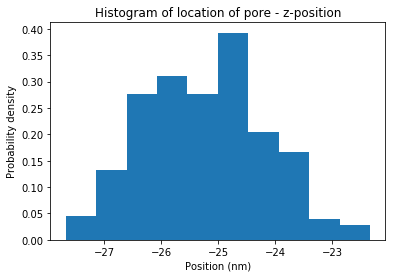

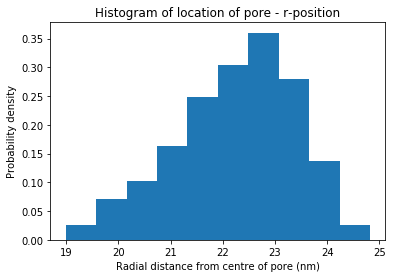

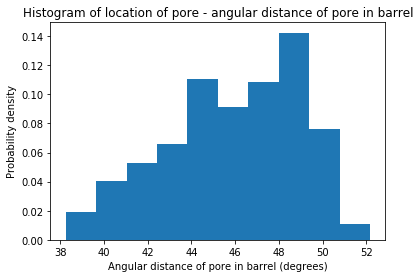

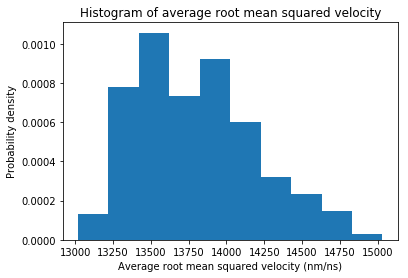

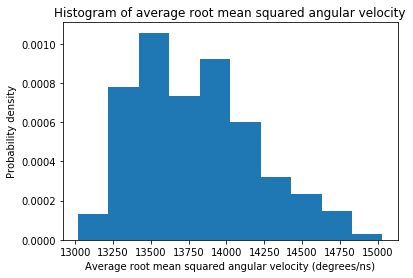

In [20]:
'''
Import data for tether length 20
'''
data = np.genfromtxt('len20/outMD.txt')

#nucleotide to track
nt = getPoreNt(20)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 1, 1))

#Get velocities
velV = takeMean(getVelocity(data, nt, 1, 1, 1))

#Get angular velocities
rotV = takeMean(getAngularV(data, nt, 1, 1, 1))

#Plot histograms
plotPositionHist(posV, 'z')
plotPositionHist(posV, 'r')
plotPositionHist(posV, 't')
plotRMSHist(velV, 'vel')
plotRMSHist(velV, 'rot')

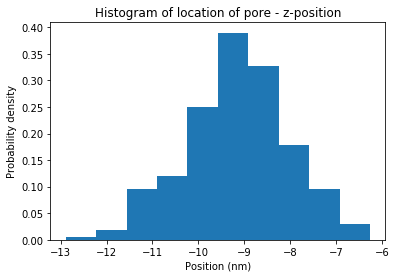

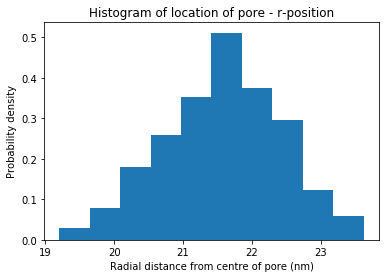

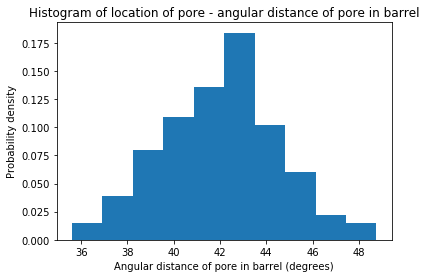

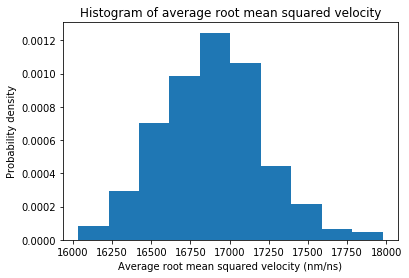

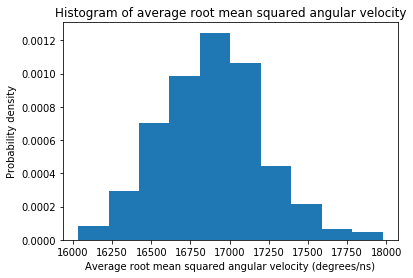

In [21]:
'''
Import data for tether length 30
'''
data = np.genfromtxt('len30/outMD.txt')

#nucleotide to track
nt = getPoreNt(30)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 1, 1))

#Get velocities
velV = takeMean(getVelocity(data, nt, 1, 1, 1))

#Get angular velocities
rotV = takeMean(getAngularV(data, nt, 1, 1, 1))

#Plot histograms
plotPositionHist(posV, 'z')
plotPositionHist(posV, 'r')
plotPositionHist(posV, 't')
plotRMSHist(velV, 'vel')
plotRMSHist(velV, 'rot')

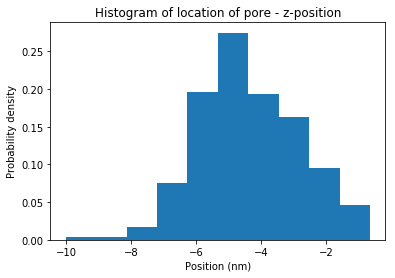

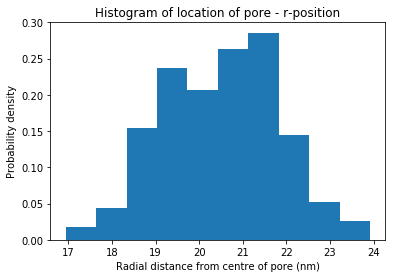

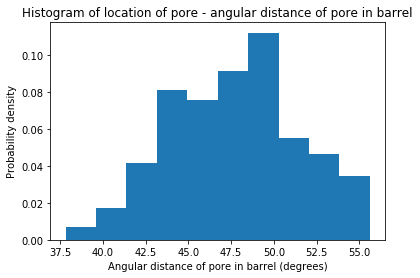

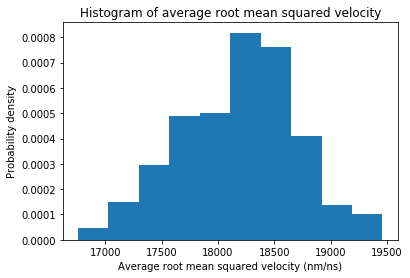

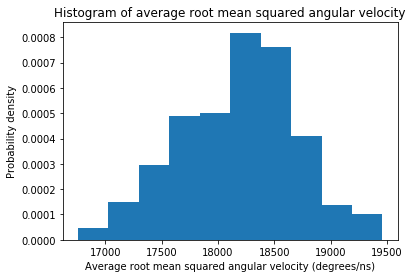

In [22]:
'''
Import data for tether length 40
'''
data = np.genfromtxt('len40/outMD.txt')

#nucleotide to track
nt = getPoreNt(40)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 1, 1))

#Get velocities
velV = takeMean(getVelocity(data, nt, 1, 1, 1))

#Get angular velocities
rotV = takeMean(getAngularV(data, nt, 1, 1, 1))

#Plot histograms
plotPositionHist(posV, 'z')
plotPositionHist(posV, 'r')
plotPositionHist(posV, 't')
plotRMSHist(velV, 'vel')
plotRMSHist(velV, 'rot')

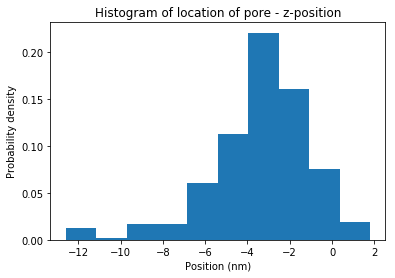

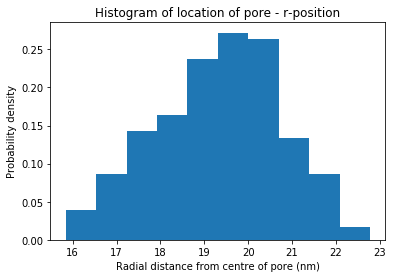

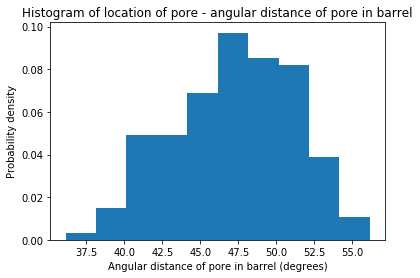

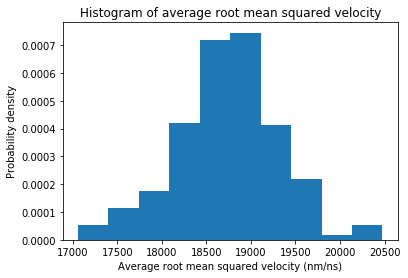

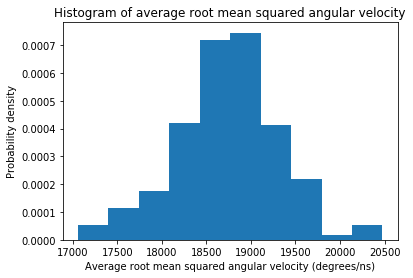

In [23]:
'''
Import data for tether length 50
'''
data = np.genfromtxt('len50/outMD.txt')

#nucleotide to track
nt = getPoreNt(50)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 1, 1))

#Get velocities
velV = takeMean(getVelocity(data, nt, 1, 1, 1))

#Get angular velocities
rotV = takeMean(getAngularV(data, nt, 1, 1, 1))

#Plot histograms
plotPositionHist(posV, 'z')
plotPositionHist(posV, 'r')
plotPositionHist(posV, 't')
plotRMSHist(velV, 'vel')
plotRMSHist(velV, 'rot')

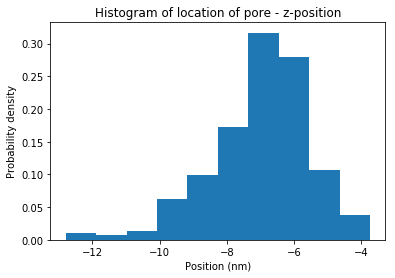

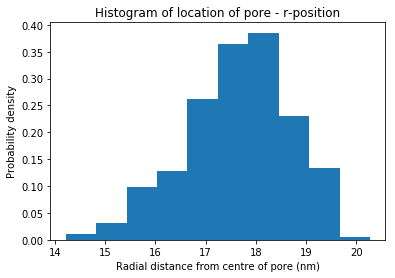

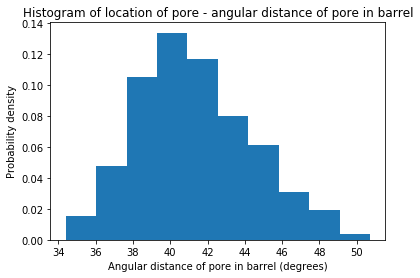

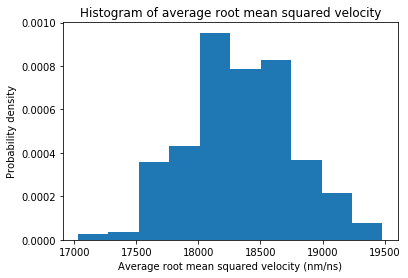

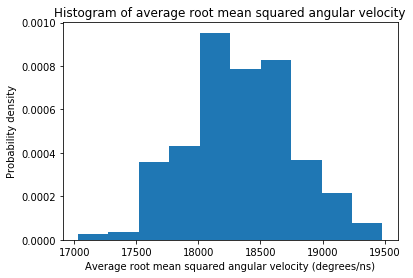

In [24]:
'''
Import data for tether length 60
'''
data = np.genfromtxt('len60/outMD.txt')

#nucleotide to track
nt = getPoreNt(60)

#Get positions
posV = takeMean(getPosition(data, nt, 1, 1, 1))

#Get velocities
velV = takeMean(getVelocity(data, nt, 1, 1, 1))

#Get angular velocities
rotV = takeMean(getAngularV(data, nt, 1, 1, 1))

#Plot histograms
plotPositionHist(posV, 'z')
plotPositionHist(posV, 'r')
plotPositionHist(posV, 't')
plotRMSHist(velV, 'vel')
plotRMSHist(velV, 'rot')

# Future work
- I was using random sequences so I can try varying the tether sequence to avoid hairpins that were observed in some simulations. 
- Also soon I will try this with cinches / handles to see if I can explain why the cinches weren't very effective. 